##              Lecture 18                    
                                            
Introduction to Time-Series Analysis      
  - time-series data manipulations        
  - data explorations:                    
      - descriptive + graphs              
      - auto-correlation                  
  - model with feols                      
      - setup feols w panel.id            
      - Newey-West standard errors        
      - lagged variables                  
      - cumulative effects w SEs          
                                            
Case Study:                                 
  - Arizona Electricity Consumption           
                                            

Import packages

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.formula.api as smf
from datetime import datetime
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from stargazer.stargazer import Stargazer
import warnings

warnings.filterwarnings("ignore")

Import data

## 1st source: climate data  (cooling degree days etc, by month)

In [2]:
climate = pd.read_csv('https://osf.io/g3tj7/download')

and convert them into date format as well: here we have an easier implemented format

In [3]:
climate["tempdate"] = climate["DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m"))

Add the same variables

In [4]:
climate["year"] = climate["tempdate"].dt.year
climate["month"] = climate["tempdate"].dt.month
climate["ym"] = climate["tempdate"]

### Data manipulation with time-series data:
 1) Generate averages from sums:
     when dividing by N, must take into account N of days

In [5]:
climate["ndays"] = np.where(
    climate["month"].isin([1, 3, 5, 7, 8, 10, 12]),
    31,
    np.where(climate["month"] == 2, 28, 30),
)

 Focus on cooling degree, heating degree 

In [6]:
climate["CLDD_avg"] = climate["CLDD"] / climate["ndays"] 
climate["HTDD_avg"] = climate["HTDD"] / climate["ndays"] 

Drop others

In [7]:
climate = climate.drop(["DATE", "tempdate", "STATION", "NAME","DX32","DX70","DX90"],axis=1)

Check the descriptive

In [8]:
climate.filter(["CLDD_avg","HTDD_avg"]).describe().T

,count,mean,std,min,25%,50%,75%,max
CLDD_avg,332.0,12.698136,11.576086,0.0,0.666667,10.163441,24.90000,33.290323
HTDD_avg,332.0,2.422917,3.525208,0.0,0.000000,0.131183,4.12068,12.129032


## 2nd source: the electricity consumption data (monthly data)

In [9]:
electricity = pd.read_csv('https://osf.io/wbef4/download')

Convert 'MY' variable into numeric date

In [10]:
electricity["date"] = electricity["MY"].apply(lambda x: datetime.strptime(x, "%b-%y"))

We can create different time variables:\
year -> the actual year\
month -> the actual month\
format -> create your own format

In [11]:
electricity["year"] = electricity["date"].dt.year
electricity["month"] = electricity["date"].dt.month
electricity["ym"] = electricity["date"]

Remove MY, year and month variables

In [12]:
electricity = electricity.drop(["MY","year","month"],axis=1)

Take logs of q (used electricity)

In [13]:
electricity["lnQ"] = np.log(electricity["Q"])

 ### Merging the two data

In [14]:
df = climate.merge(electricity,on ="ym",how="inner")

Restrict the sample between years 2001 and 2017

In [15]:
df = df.loc[(df["year"] >= 2001) & (df["year"] <= 2017)]

## Data exploration

In [16]:
df.filter(["Q", "lnQ", "CLDD_avg", "HTDD_avg"]).describe().T

,count,mean,std,min,25%,50%,75%,max
Q,204.0,2636.392157,864.697489,1404.000000,1938.250000,2338.500000,3309.750000,4674.000000
lnQ,204.0,7.827744,0.309525,7.247081,7.569541,7.757263,8.104615,8.449771
CLDD_avg,204.0,13.317995,11.779998,0.000000,1.104551,10.333333,25.875000,33.290323
HTDD_avg,204.0,2.283919,3.499287,0.000000,0.000000,0.016667,3.737500,12.096774


## Plot the time series

Consumption

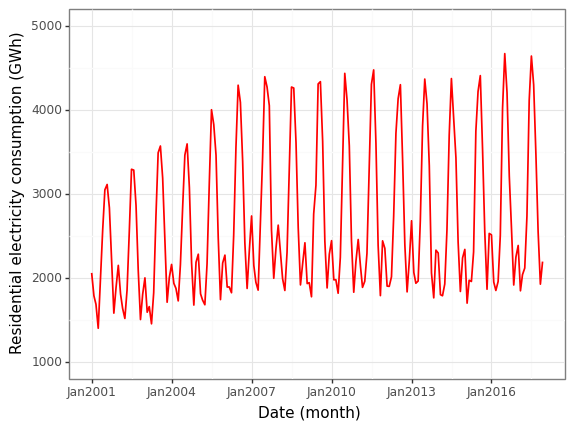

<ggplot: (352209170)>

In [17]:
limits = datetime(2001, 1, 1), datetime(2018, 1, 1)
breaks = date_breaks("3 year")

(
    ggplot(df, aes(x="date", y="Q"))
    + geom_line(color="red", size=0.7)
    + ylab("Residential electricity consumption (GWh)")
    + xlab("Date (month)")
    + scale_y_continuous(limits=(1000, 5000), breaks=np.arange(1000, 5001, 1000))
    + scale_x_date(breaks=breaks(limits)[::1], labels=date_format("%b%Y"))
    + theme_bw()
)

Log-consumption

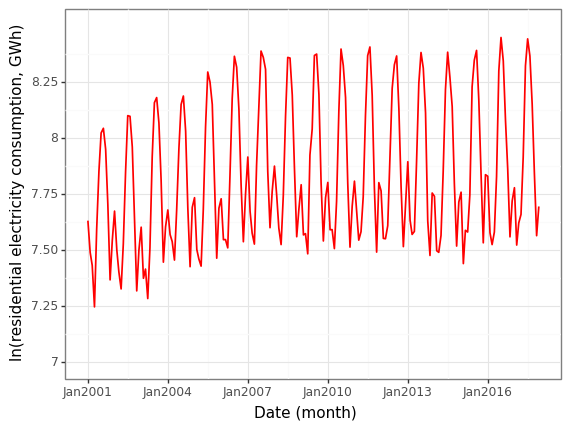

<ggplot: (352209680)>

In [18]:
(
    ggplot(df, aes(x="date", y="lnQ"))
    + geom_line(color="red", size=0.7)
    + ylab("ln(residential electricity consumption, GWh)")
    + xlab("Date (month)")
    + scale_y_continuous(limits=(7, 8.5), breaks=np.arange(7, 8.5, 0.25))
    + scale_x_date(breaks=breaks(limits)[::1], labels=date_format("%b%Y"))
    + theme_bw()
)

 Cooling degrees

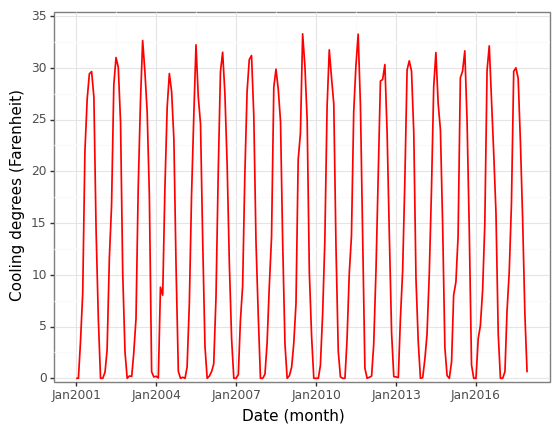

<ggplot: (373334617)>

In [19]:
(
    ggplot(df, aes(x="date", y="CLDD_avg"))
    + geom_line(color="red", size=0.7)
    + ylab("Cooling degrees (Farenheit)")
    + xlab("Date (month)")
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 35), breaks=np.arange(0, 36, 5)
    )
    + scale_x_date(breaks=breaks(limits)[::1], labels=date_format("%b%Y"))
    + theme_bw()
)

Heating degrees

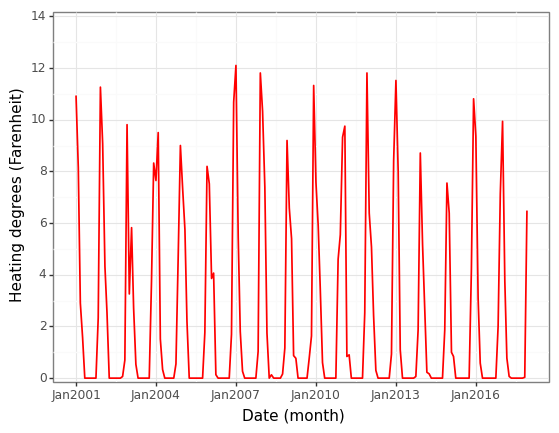

<ggplot: (373401447)>

In [20]:
(
    ggplot(df, aes(x="date", y="HTDD_avg"))
    + geom_line(color="red", size=0.7)
    + ylab("Heating degrees (Farenheit)")
    + xlab("Date (month)")
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 14), breaks=np.arange(0, 15, 2)
    )
    + scale_x_date(breaks=breaks(limits)[::1], labels=date_format("%b%Y"))
    + theme_bw()
)

Plot all of them together

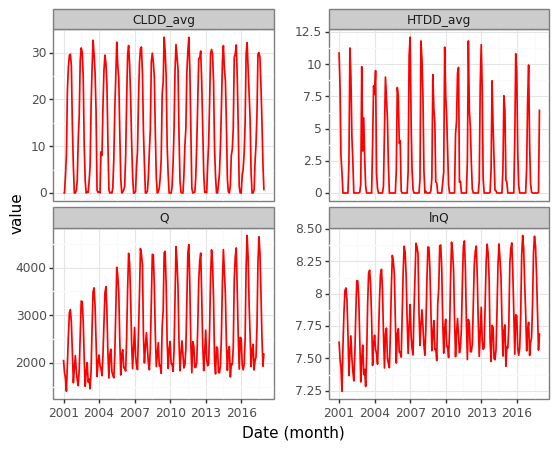

<ggplot: (373484481)>

In [21]:
(
    ggplot(
        df.melt(id_vars="date", value_vars=["CLDD_avg", "HTDD_avg", "lnQ", "Q"]),
        aes(x="date", y="value"),
    )
    + geom_line(color="red", size=0.7)
    + facet_wrap("~variable", scales="free_y")
    + xlab("Date (month)")
    + scale_x_date(breaks=breaks(limits)[::1], labels=date_format("%Y"))
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25})
)

### Time-series specific analysis

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

Log of electricity consumption

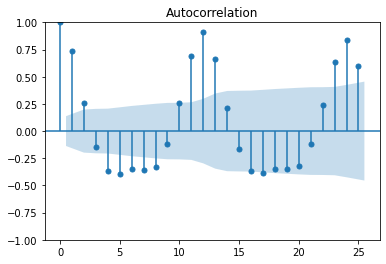

In [23]:
plot_acf(df["lnQ"], lags = 25)
plt.show()

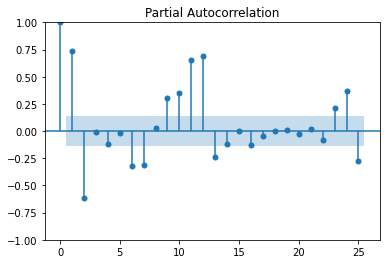

In [24]:
plot_pacf(df["lnQ"], lags = 25, method = "ols")
plt.show()

Cooling degree

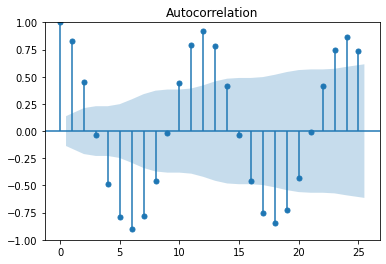

In [25]:
plot_acf(df["CLDD_avg"], lags = 25)
plt.show()

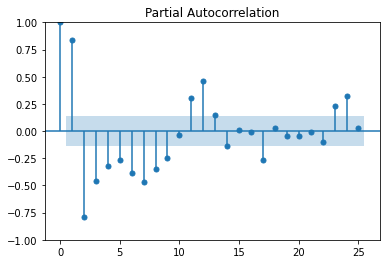

In [26]:
plot_pacf(df["CLDD_avg"], lags = 25, method = "ols")
plt.show()

Heating degree

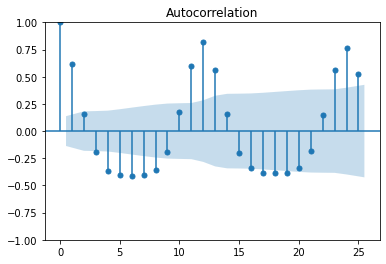

In [27]:
plot_acf(df["HTDD_avg"], lags = 25)
plt.show()

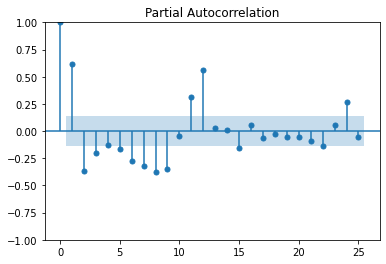

In [28]:
plot_pacf(df["HTDD_avg"], lags = 25, method = "ols")
plt.show()

Solution --> Create differences

In [29]:
df["DlnQ"] = df["lnQ"] - df["lnQ"].shift(1)
df["DCLDD_avg"] = df["CLDD_avg"] - df["CLDD_avg"].shift(1)
df["DHTDD_avg"] = df["HTDD_avg"] - df["HTDD_avg"].shift(1)

### Functional form investigations 

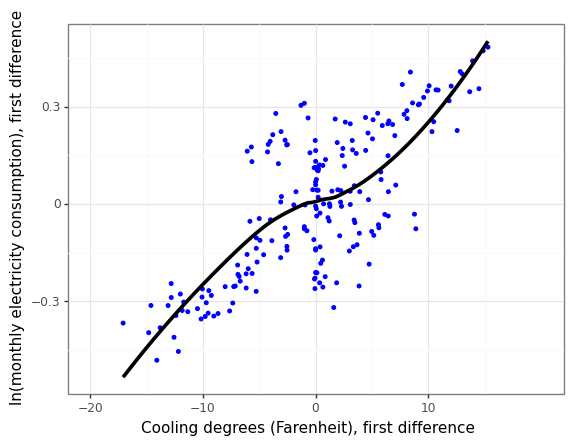

<ggplot: (373355145)>

In [30]:
(
    ggplot(df, aes(x="DCLDD_avg", y="DlnQ"))
    + geom_point(size=1, fill="blue", color="blue")
    + geom_smooth(
        method="loess", se=False, colour="black", size=1.5, span=0.9,
    )
    + labs(
        x="Cooling degrees (Farenheit), first difference",
        y="ln(monthly electricity consumption), first difference",
    )
    + scale_x_continuous(limits=(-20, 20), breaks=np.arange(-20, 20, 10))
    + theme_bw()
)

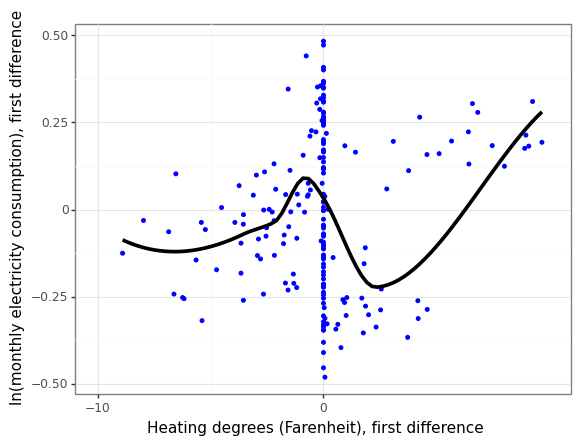

<ggplot: (352208963)>

In [31]:
(
    ggplot(df, aes(x="DHTDD_avg", y="DlnQ"))
    + geom_point(size=1, fill="blue", color="blue")
    + geom_smooth(method="loess", se=False, colour="black", size=1.5)
    + labs(
        x="Heating degrees (Farenheit), first difference",
        y="ln(monthly electricity consumption), first difference",
    )
    + scale_x_continuous(limits=(-10, 10), breaks=np.arange(-10, 10, 10))
    + theme_bw()
)

### Linear regressions

- reg1: DlnQ = alpha + beta_1 * DCLDD_avg + beta_2 * DHTDD_avg
- reg2: DlnQ = alpha + beta_1 * DCLDD_avg + beta_2 * DHTDD_avg + months
- reg3: DlnQ = alpha + gamma * lag( DlnQ ) + beta_1 * DCLDD_avg + beta_2 * DHTDD_avg + months
- reg4: DlnQ = alpha + beta_1 * DCLDD_avg + beta_2 * DHTDD_avg + months + 2 LAGS of DCLDD_avg and DHTDD_avg
- reg_cumSE: use reg4 but estimate standard errors for the cumulative effect

In [32]:
df = df.sort_values(by="ym")

In [33]:
reg1 = smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg", data=df).fit()
reg1.get_robustcov_results(cov_type="HAC", maxlags=24).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1122.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):          1.91e-109
Time:                        00:01:58   Log-Likelihood:                 182.98
No. Observations:                 203   AIC:                            -360.0
Df Residuals:                     200   BIC:                            -350.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.002      0.622      0.535      -0.002       0.004
DCLDD_avg      0.0307      0.001     31.553      0.000       0.029       0.033
DHTDD_avg      0.0367      0.004     10.102      0.000       0.030       0.044
==============================================================================
Omnibus:                        4.221   Durbin-Watson:                   2.547
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                4.632
Skew:                          -0.164   Prob(JB):                       0.0986
Kurtosis:                       3.664   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

In [34]:
reg2 = smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month)", data=df).fit()
reg2.get_robustcov_results(cov_type="HAC", maxlags=24).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     2801.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):          2.19e-208
Time:                        00:01:58   Log-Likelihood:                 321.40
No. Observations:                 203   AIC:                            -614.8
Df Residuals:                     189   BIC:                            -568.4
Df Model:                          13                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0919      0.013      7.014      0.000       0.066       0.118
C(month)[T.2]     -0.2740      0.017    -16.433      0.000      -0.307      -0.241
C(month)[T.3]     -0.1219      0.025     -4.839      0.000      -0.172      -0.072
C(month)[T.4]     -0.1837      0.030     -6.092      0.000      -0.243      -0.124
C(month)[T.5]      0.0327      0.012      2.778      0.006       0.009       0.056
C(month)[T.6]      0.0807      0.032      2.550      0.012       0.018       0.143
C(month)[T.7]      0.0580      0.012      4.674      0.000       0.034       0.083
C(month)[T.8]     -0.0854      0.014     -5.896      0.000      -0.114      -0.057
C(month)[T.9]     -0.1757      0.014    -12.206      0.000      -0.204      -0.147
C(month)[T.10]    -0.2464      0.030     -8.151      0.000      -0.306      -0.187
C(month)[T.11]    -0.2418      0.036     -6.783      0.000      -0.312      -0.171
C(month)[T.12]     0.0672      0.021      3.260      0.001       0.027       0.108
DCLDD_avg          0.0169      0.003      6.563      0.000       0.012       0.022
DHTDD_avg          0.0140      0.003      4.028      0.000       0.007       0.021
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.428
Skew:                          -0.047   Prob(JB):                        0.808
Kurtosis:                       2.796   Cond. No.                         90.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

Compare the two models

In [35]:
table = Stargazer([reg1, reg2])
table

reg3: include the lag of DlnQ:

In [36]:
reg3 = smf.ols("DlnQ ~ DlnQ.shift(1) + DCLDD_avg + DHTDD_avg + C(month)", data=df).fit()
reg3.get_robustcov_results(cov_type="HAC", maxlags=24).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     3159.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):          8.33e-214
Time:                        00:01:58   Log-Likelihood:                 320.67
No. Observations:                 202   AIC:                            -611.3
Df Residuals:                     187   BIC:                            -561.7
Df Model:                          14                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0923      0.022      4.127      0.000       0.048       0.136
C(month)[T.2]     -0.2792      0.020    -13.811      0.000      -0.319      -0.239
C(month)[T.3]     -0.1228      0.044     -2.767      0.006      -0.210      -0.035
C(month)[T.4]     -0.1843      0.037     -4.938      0.000      -0.258      -0.111
C(month)[T.5]      0.0319      0.015      2.195      0.029       0.003       0.061
C(month)[T.6]      0.0805      0.032      2.484      0.014       0.017       0.144
C(month)[T.7]      0.0582      0.020      2.864      0.005       0.018       0.098
C(month)[T.8]     -0.0854      0.015     -5.837      0.000      -0.114      -0.057
C(month)[T.9]     -0.1761      0.025     -7.070      0.000      -0.225      -0.127
C(month)[T.10]    -0.2470      0.053     -4.649      0.000      -0.352      -0.142
C(month)[T.11]    -0.2427      0.067     -3.632      0.000      -0.375      -0.111
C(month)[T.12]     0.0661      0.041      1.596      0.112      -0.016       0.148
DlnQ.shift(1)     -0.0021      0.064     -0.033      0.974      -0.129       0.125
DCLDD_avg          0.0169      0.003      5.817      0.000       0.011       0.023
DHTDD_avg          0.0140      0.004      3.862      0.000       0.007       0.021
==============================================================================
Omnibus:                        0.182   Durbin-Watson:                   2.406
Prob(Omnibus):                  0.913   Jarque-Bera (JB):                0.322
Skew:                          -0.043   Prob(JB):                        0.851
Kurtosis:                       2.824   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

reg4: include the lag of heating/cooling degrees up to two lags

In [37]:
reg4 = smf.ols(
    "DlnQ ~ DCLDD_avg + DCLDD_avg.shift(1) + DCLDD_avg.shift(2) + DHTDD_avg + DHTDD_avg.shift(1) + DHTDD_avg.shift(2) + C(month)",
    data=df,
).fit()
reg4.get_robustcov_results(cov_type="HAC", maxlags=24).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     4592.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):          9.21e-231
Time:                        00:01:58   Log-Likelihood:                 330.98
No. Observations:                 201   AIC:                            -626.0
Df Residuals:                     183   BIC:                            -566.5
Df Model:                          17                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0466      0.025      1.901      0.059      -0.002       0.095
C(month)[T.2]         -0.2064      0.024     -8.549      0.000      -0.254      -0.159
C(month)[T.3]         -0.0414      0.039     -1.052      0.294      -0.119       0.036
C(month)[T.4]         -0.1239      0.043     -2.905      0.004      -0.208      -0.040
C(month)[T.5]          0.0383      0.044      0.872      0.384      -0.048       0.125
C(month)[T.6]          0.0415      0.048      0.862      0.390      -0.053       0.137
C(month)[T.7]          0.0239      0.053      0.454      0.650      -0.080       0.128
C(month)[T.8]         -0.0641      0.035     -1.814      0.071      -0.134       0.006
C(month)[T.9]         -0.1085      0.030     -3.567      0.000      -0.168      -0.048
C(month)[T.10]        -0.1358      0.034     -4.048      0.000      -0.202      -0.070
C(month)[T.11]        -0.1054      0.044     -2.420      0.016      -0.191      -0.019
C(month)[T.12]         0.1335      0.026      5.105      0.000       0.082       0.185
DCLDD_avg              0.0200      0.003      7.786      0.000       0.015       0.025
DCLDD_avg.shift(1)     0.0060      0.002      2.788      0.006       0.002       0.010
DCLDD_avg.shift(2)     0.0009      0.002      0.576      0.565      -0.002       0.004
DHTDD_avg              0.0191      0.003      5.727      0.000       0.012       0.026
DHTDD_avg.shift(1)     0.0112      0.003      3.271      0.001       0.004       0.018
DHTDD_avg.shift(2)     0.0002      0.003      0.065      0.948      -0.005       0.005
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   2.401
Prob(Omnibus):                  0.989   Jarque-Bera (JB):                0.106
Skew:                          -0.018   Prob(JB):                        0.949
Kurtosis:                       2.894   Cond. No.                         371.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

In [38]:
table = Stargazer([reg1, reg2, reg3, reg4])
table

 Note: to be fair, one needs to use a restricted sample with 201 observations in this case!

### Task:
Replicate these results, but now using the same sample for each model to ensure fair comparison!\
You should have the same number of observations in the end

In [39]:
reg1_s= smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg", data=df.iloc[3:, :]).fit()
reg2_s = smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month)", data=df.iloc[3:, :]).fit()
reg3_s = smf.ols(
    "DlnQ ~ DlnQ.shift(1) + DCLDD_avg + DHTDD_avg + C(month)", data=df.iloc[2:, :]
).fit()
reg4_s = smf.ols(
    "DlnQ ~ DCLDD_avg + DCLDD_avg.shift(1) + DCLDD_avg.shift(2) + DHTDD_avg + DHTDD_avg.shift(1) + DHTDD_avg.shift(2) + C(month)",
    data=df,
).fit()

In [40]:
table = Stargazer([reg1_s, reg2_s, reg3_s, reg4_s])
table

Trick to estimate SE on the cumulative effect

 1) create double differenced variable

In [41]:
df["DDCLDD_avg"] = df["DCLDD_avg"] - df["DCLDD_avg"].shift(1)
df["DDHTDD_avg"] = df["DHTDD_avg"] - df["DHTDD_avg"].shift(1)

In [42]:
reg_cumSE = smf.ols(
    "DlnQ ~ DCLDD_avg.shift(2) + DHTDD_avg.shift(2) + DDCLDD_avg + DCLDD_avg.shift(1) + DDHTDD_avg + DDHTDD_avg.shift(1) + C(month)",
    data=df,
).fit()
reg_cumSE.get_robustcov_results(cov_type="HAC", maxlags=24).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     4592.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):          9.21e-231
Time:                        00:01:58   Log-Likelihood:                 330.98
No. Observations:                 201   AIC:                            -626.0
Df Residuals:                     183   BIC:                            -566.5
Df Model:                          17                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0466      0.025      1.901      0.059      -0.002       0.095
C(month)[T.2]          -0.2064      0.024     -8.549      0.000      -0.254      -0.159
C(month)[T.3]          -0.0414      0.039     -1.052      0.294      -0.119       0.036
C(month)[T.4]          -0.1239      0.043     -2.905      0.004      -0.208      -0.040
C(month)[T.5]           0.0383      0.044      0.872      0.384      -0.048       0.125
C(month)[T.6]           0.0415      0.048      0.862      0.390      -0.053       0.137
C(month)[T.7]           0.0239      0.053      0.454      0.650      -0.080       0.128
C(month)[T.8]          -0.0641      0.035     -1.814      0.071      -0.134       0.006
C(month)[T.9]          -0.1085      0.030     -3.567      0.000      -0.168      -0.048
C(month)[T.10]         -0.1358      0.034     -4.048      0.000      -0.202      -0.070
C(month)[T.11]         -0.1054      0.044     -2.420      0.016      -0.191      -0.019
C(month)[T.12]          0.1335      0.026      5.105      0.000       0.082       0.185
DCLDD_avg.shift(2)      0.0009      0.002      0.576      0.565      -0.002       0.004
DHTDD_avg.shift(2)      0.0304      0.007      4.112      0.000       0.016       0.045
DDCLDD_avg              0.0200      0.003      7.786      0.000       0.015       0.025
DCLDD_avg.shift(1)      0.0260      0.003      7.686      0.000       0.019       0.033
DDHTDD_avg              0.0191      0.003      5.727      0.000       0.012       0.026
DDHTDD_avg.shift(1)     0.0303      0.005      5.514      0.000       0.019       0.041
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   2.401
Prob(Omnibus):                  0.989   Jarque-Bera (JB):                0.106
Skew:                          -0.018   Prob(JB):                        0.949
Kurtosis:                       2.894   Cond. No.                         343.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

Compare the results

In [43]:
table = Stargazer([reg4, reg_cumSE])
table

Remark - from reg4: DCLDD_avg+l(DCLDD_avg,1)+l(DCLDD_avg,2) == reg_cumSE: l(DCLDD_avg,2) \
  extra: for reg_cumSE: l(DCLDD_avg,2) we have SE as well! \
  same for l(DHTDD_avg,2)